In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import tqdm
from tqdm.notebook import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

import torch
from torch import nn

from nilearn.plotting import plot_glass_brain
import nibabel as nib

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from adapters import AutoAdapterModel

from neurovlm.data import fetch_data
from neurovlm.coords import coords_to_vectors
from neurovlm.models import NeuroAutoEncoder, TextAligner
from neurovlm.train import Trainer, which_device
device = which_device()

/Users/borng/code/lab_work/neurovlm/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training

This notebook trains the `neurovlm` model. Sections include:

1. Load coordinates
2. Extract neuro-vectors
3. Train autoencoder
4. Train text aligner
5. Results

## 1. Load Coordinates

Data from 25k articles, fetched and processed with `pubget`.

- article id
- titles
- dois
- MNI coordinates

In [2]:
data_dir = fetch_data()
df_pubs = pd.read_parquet(f"{data_dir}/publications.parquet")
df_coords = pd.read_parquet(f"{data_dir}/coordinates.parquet")

In [3]:
df_coords

,pmid,pmcid,doi,x,y,z
0,22884992,NaN,10.1016/j.dcn.2012.07.001,-57,-22,34
1,22884992,NaN,10.1016/j.dcn.2012.07.001,-54,11,13
2,22884992,NaN,10.1016/j.dcn.2012.07.001,-51,-49,-2
3,22884992,NaN,10.1016/j.dcn.2012.07.001,-48,-1,37
4,22884992,NaN,10.1016/j.dcn.2012.07.001,-46,37,-6
...,...,...,...,...,...,...
766236,35710930,9203582.0,10.1038/s41598-022-14221-x,42,34,32
766237,35710930,9203582.0,10.1038/s41598-022-14221-x,45,33,28
766238,35710930,9203582.0,10.1038/s41598-022-14221-x,46,18,-10
766239,35710930,9203582.0,10.1038/s41598-022-14221-x,51,-42,18


## 2. Extract Neuro-vectors

Smooth coordinates with 9mm Gaussian kernel and extract a 28542 dimensional vector. The vector is binarized and the autoencoder will minimize binary cross entropy.

In [4]:
# Convert coordinates to MNI space vectors
neuro_vectors, df_pubs = coords_to_vectors(df_coords, df_pubs)

# Binarize for classification
neuro_vectors[neuro_vectors > 0.0] = 1.0
neuro_vectors = neuro_vectors.to("cpu")

# Save
torch.save(neuro_vectors, "neuro_vectors.pt")
df_pubs.to_csv("publications.csv")

  0%|          | 0/28393 [00:00<?, ?it/s]

In [31]:
# Skip above if previously trained
neuro_vectors = torch.load(
    "specter/neuro_vectors.pt", weights_only=True
).to("cpu")



## 3. Train Autoencoder

Train an autoencoder on the neuro-vectors.

1. Encoder: Neuro-vector to low-dimensional (384) latent vector / embedding space

2. Decoder: Latent vector to produces MNI space predictions.

The 384 latent dimension was chosen to match the latent dimension of the chosen text encoder.

In [32]:
# Train/test/validation split
inds = torch.arange(len(neuro_vectors))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)

In [ ]:
# Train
trainer = Trainer(
    NeuroAutoEncoder(seed=0),
    n_epochs=100,
    batch_size=256,
    lr=1e-4,
    loss_fn=nn.BCELoss(),
    optimizer=torch.optim.AdamW,
    X_val=neuro_vectors[val_inds],
    device="auto"
)

# Fit
trainer.fit(neuro_vectors[train_inds])

# Save
trainer.save("autoencoder.pt")

# Unpack
autoencoder = trainer.model

Epoch: 99,  val loss:  0.69321 (initial) -> 0.15089 (current)

In [15]:
# Skip above if previously trained
autoencoder = torch.load(
    "specter/autoencoder.pt", weights_only=False
).to("cpu")

## 4. Train Text Encoder

Use SPECTER pre-trained language model to compute latent text vectors for each publication's title and it's corresponding abstract. For other transformers, see the `sentence-transformers` package. The `TextAligner` model transforms latext text to latent MNI space and dimension. Then the neuro-decoder can transform the aligned latent text, to MNI space, resulting in a generative model.


### Encoding the titles and abstract

In [11]:
# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_aug2023refresh_base')

#load base model
model = AutoAdapterModel.from_pretrained("allenai/specter2_aug2023refresh_base")

#load the proximity adapter, provide an identifier for the adapter in load_as argument and activate it
model.load_adapter("allenai/specter2", source="hf", load_as="specter2_proximity", set_active=True)





Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

'specter2_proximity'

In [26]:
def embed_input(text_batch: list[str]):
  # preprocess the input
  inputs = tokenizer(text_batch, padding=True, truncation=True,
                                   return_tensors="pt", return_token_type_ids=False, max_length=512)
  output = model(**inputs)
  # take the first token in the batch as the embedding
  embeddings = output.last_hidden_state[:, 0, :]
  return embeddings




In [13]:
# Extract title and abstract from dataFrame in the format appropriate for specter.
papers = [{'title': title, 'abstract': abstract} for title, abstract in zip(df_pubs['name'], df_pubs['description'])]

# concatenate title and abstract
text_batch = [d['title'] + tokenizer.sep_token + (d.get('abstract') or '') for d in papers]




In [14]:
# Calculate total number of batches needed
total_samples = 28393
batch_size = 8
total_batches = (total_samples + batch_size - 1) // batch_size

# Create batches directory if it doesn't exist
os.makedirs('batches', exist_ok=True)

# Start from batch 3025 since 3024 was the last completed batch
current_batch = 3095

for i in tqdm(range(current_batch - 1, total_batches)):
    # Calculate start and end indices for current batch
    start_idx = (current_batch - 1) * batch_size
    end_idx = min(start_idx + batch_size, total_samples)

    # Get current batch
    batch = text_batch[start_idx:end_idx]

    # Embed the batch
    latent_batch = embed_input(batch)

    # Save current batch embeddings
    torch.save(latent_batch, f"batches/latent_text_batch_{current_batch}.pt")

    # Increment batch counter
    current_batch += 1

    print(f"\rProcessed batch {current_batch-1} ({start_idx+1}-{end_idx} of {total_samples} samples)", end='')

# Code to combine all batches once complete:
"""
# Combine all batch files
latent_text_batches = []
for i in range(1, total_batches + 1):
    batch_tensor = torch.load(f"batches/latent_text_batch_{i}.pt")
    latent_text_batches.append(batch_tensor)
    
latent_text = torch.cat(latent_text_batches, dim=0)
torch.save(latent_text, "latent_text.pt")
"""

  0%|          | 0/456 [00:00<?, ?it/s]

Processed batch 3550 (28393-28393 of 28393 samples)

'\n# Combine all batch files\nlatent_text_batches = []\nfor i in range(1, total_batches + 1):\n    batch_tensor = torch.load(f"batches/latent_text_batch_{i}.pt")\n    latent_text_batches.append(batch_tensor)\n\nlatent_text = torch.cat(latent_text_batches, dim=0)\ntorch.save(latent_text, "latent_text.pt")\n'

In [8]:
batch_tensor = torch.load(f"batches/latent_text_batch_{1}.pt")

In [16]:
# Get total number of batches
total_batches = 3550
chunk_size = total_batches // 4

# Process first quarter
print("Processing first quarter...")
latent_text_first_batches = []
for i in tqdm(range(1, chunk_size + 1)):
    batch_tensor = torch.load(f"batches/latent_text_batch_{i}.pt")
    latent_text_first_batches.append(batch_tensor)

latent_text_first = torch.cat(latent_text_first_batches, dim=0)
torch.save(latent_text_first, "latent_text_first_quarter.pt")


# Process second quarter
print("Processing second quarter...")
latent_text_second_batches = []
for i in tqdm(range(chunk_size + 1, chunk_size * 2 + 1)):
    batch_tensor = torch.load(f"batches/latent_text_batch_{i}.pt")
    latent_text_second_batches.append(batch_tensor)

latent_text_second = torch.cat(latent_text_second_batches, dim=0)
torch.save(latent_text_second, "latent_text_second_quarter.pt")


# Process third quarter
print("Processing third quarter...")
latent_text_third_batches = []
for i in tqdm(range(chunk_size * 2 + 1, chunk_size * 3 + 1)):
    batch_tensor = torch.load(f"batches/latent_text_batch_{i}.pt")
    latent_text_third_batches.append(batch_tensor)

latent_text_third = torch.cat(latent_text_third_batches, dim=0)
torch.save(latent_text_third, "latent_text_third_quarter.pt")


# Process fourth quarter
print("Processing fourth quarter...")
latent_text_fourth_batches = []
for i in tqdm(range(chunk_size * 3 + 1, total_batches + 1)):
    batch_tensor = torch.load(f"batches/latent_text_batch_{i}.pt")
    latent_text_fourth_batches.append(batch_tensor)

latent_text_fourth = torch.cat(latent_text_fourth_batches, dim=0)
torch.save(latent_text_fourth, "latent_text_fourth_quarter.pt")

# Combine all quarters
print("Combining quarters...")
latent_text = torch.cat([
    torch.load("latent_text_first_quarter.pt"),
    torch.load("latent_text_second_quarter.pt"),
    torch.load("latent_text_third_quarter.pt"),
    torch.load("latent_text_fourth_quarter.pt")
], dim=0)
torch.save(latent_text, "latent_text.pt")

print("Complete!")


Processing first quarter...


  0%|          | 0/887 [00:00<?, ?it/s]

### Continue training

In [ ]:
# Load latent text vectors
with torch.no_grad():
    latent_text = torch.load("specter/latent_text.pt").to("cpu").detach()


In [21]:
# Encode MNI vectors
with torch.no_grad():
    latent_neuro = autoencoder.encoder(
        neuro_vectors.to("cpu")
    ).detach()

In [28]:
# Train
align_trainer = Trainer(
    TextAligner(
        latent_text_dim = 768,
        hidden_dim = 384,
        latent_neuro_dim = 384,
        seed=0),
    n_epochs=500,
    batch_size=1028,
    lr=2e-4,
    loss_fn=nn.MSELoss(),
    optimizer=torch.optim.AdamW,
    X_val=latent_text[val_inds],
    y_val=latent_neuro[val_inds],
    device="auto"
)

# Fit
align_trainer.fit(
    latent_text[train_inds],
    latent_neuro[train_inds]
)

# Save
align_trainer.save("aligner.pt")


# Unpack
aligner = align_trainer.model

KeyboardInterrupt: 

In [7]:
# Skip above if previously trained
aligner = torch.load(
    "specter/aligner.pt", weights_only=False
).to(device)

## 5. Results

Lastly, test predictions are made on "vision" and "motor" and plotted. These results correspond to the visual and motor cortices, respectively. The next tutorial explores vector projection for when a query is out-of-sample or uncommon in neuroscience research, yet has semantic mappings to other neuroscientific terms.

In [24]:
# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_aug2023refresh_base')

#load base model
model = AutoAdapterModel.from_pretrained("allenai/specter2_aug2023refresh_base")

model.load_adapter("allenai/specter2_adhoc_query", source="hf", load_as="specter2_adhoc_query", set_active=True)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

'specter2_adhoc_query'

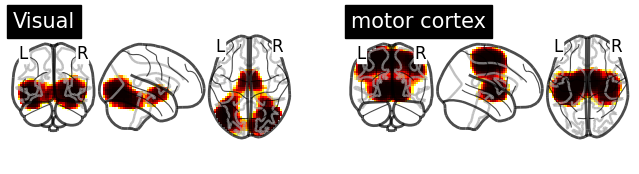

In [27]:
# Load mask
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask = mask_arrays["mask"]
affine = mask_arrays["affine"]

# Test queries
queries = ["Visual", "motor cortex"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
for i, query in enumerate(queries):
    # Encode text
    query_embedding = embed_input(query)
    
    # Align text
    aligned_text = aligner.to("cpu")(query_embedding)
    
    # Decode brain
    neuro_pred = autoencoder.to("cpu").decoder(aligned_text) \
              .detach().cpu().numpy().squeeze()


    # Plot
    pred = np.zeros(mask.shape)
    pred[mask] = neuro_pred
    img = nib.Nifti1Image(pred, affine)
    plot_glass_brain(img, threshold=.5, vmin=.5, vmax=1,
                     title=query, axes=axes[i]);

In [12]:
neuro_pred

array([0.01357393, 0.01728342, 0.02010185, ..., 0.01850935, 0.0231086 ,
       0.02147684], shape=(28542,), dtype=float32)

In [16]:
latent_text.size()

torch.Size([28393, 768])

In [17]:
len(df_pubs)

28393